In [3]:
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, auc, roc_curve
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from tqdm import tqdm


from sklearn.preprocessing import StandardScaler

df_processed = pd.read_parquet('data/processed_dataset.parquet')
df_top_features = pd.read_parquet('data/top_features.parquet')

In [4]:
def get_predictions(model, X_test):
    predictions_prob = model.predict_proba(X_test)
    predictions = model.predict(X_test)
    return predictions, predictions_prob

# Make DataFrame
def make_df(predictions_prob, predictions, test, season):
    predictions_df = pd.DataFrame({
        'Season': season,
        'Date': test['Date'].values,
        'Home_Team': test['TEAM_NAME'].values,
        'Home_Prob': predictions_prob[:, 1].flatten(),
        "Home_Binary": predictions.flatten(),
        'Away_Team': test['TEAM_NAME.1'].values,
        'Away_Prob': (1 - predictions_prob[:, 1]).flatten(),
        'Away_Binary': (1 - predictions).flatten(),
        'Home_Team_Win': test['Target'].values
    })
    return predictions_df

def get_accuracy(predictions, test, season):
    return pd.DataFrame({
        'Season': season,
        'Accuracy': round(accuracy_score(test['Target'], predictions), 4),
        'F1': round(f1_score(test['Target'], predictions), 4),
        'AUC': round(roc_auc_score(test['Target'], predictions), 4)
    }, index=[0])

def backtest_ensemble(data, predictors, start=3, step=1):
    seasons = sorted(data['Season'].unique())
    prob_dfs = []
    acc_dfs = []
    
    for i in tqdm(range(start, len(seasons), step)):
        train = data[data['Season'] < seasons[i]]
        test = data[data['Season'] == seasons[i]]
        
        # Initialize models fresh for each iteration
        lr_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(max_iter=1000, solver='saga', random_state=42, n_jobs=-1, C=0.1, penalty='l2'))
        ])
        
        rf = RandomForestClassifier(
            random_state=42, 
            n_jobs=-1, 
            n_estimators=600, 
            max_depth=8
        )
        
        xgb = XGBClassifier(
            objective='binary:logistic', 
            n_jobs=-1, 
            random_state=42, 
            learning_rate=0.01, 
            n_estimators=300, 
            max_depth=3
        )
        
        # Create and fit individual models
        lr_pipeline.fit(train[predictors], train['Target'])
        rf.fit(train[predictors], train['Target'])
        xgb.fit(train[predictors], train['Target'])
        
        # Get probabilities from each model
        lr_proba = lr_pipeline.predict_proba(test[predictors])
        rf_proba = rf.predict_proba(test[predictors])
        xgb_proba = xgb.predict_proba(test[predictors])
        
        # Average the probabilities (soft voting)
        predictions_prob = (lr_proba + rf_proba + xgb_proba) / 3
        predictions = (predictions_prob[:, 1] >= 0.5).astype(int)
        
        prob_dfs.append(make_df(predictions_prob, predictions, test, seasons[i]))
        acc_dfs.append(get_accuracy(predictions, test, seasons[i]))
    
    return pd.concat(prob_dfs), pd.concat(acc_dfs)



# Update predictors list
meta_cols = ['Season', 'Date', 'Date.1', 'OU-Cover', 'OU', 'Target', 'TEAM_NAME', 'TEAM_NAME.1', 'index']
predictors_original = [col for col in df_processed.columns if col not in meta_cols]
predictors_top_features = [col for col in df_top_features.columns if col not in meta_cols]

# Run the backtest
prob_df_processed, acc_df_processed = backtest_ensemble(df_processed, predictors_original, start=4, step=1)

# Run the backtest for top features
prob_df_top_features, acc_df_top_features = backtest_ensemble(df_top_features, predictors_top_features, start=4, step=1)



100%|██████████| 8/8 [00:16<00:00,  2.04s/it]


In [5]:
print("Orginal Features")
# calculate average total accuracy, f1, and auc, and remove seasons column
acc_df_processed.mean().round(3).drop('Season')

Orginal Features


Accuracy    0.639
F1          0.707
AUC         0.619
dtype: float64

In [6]:
print("PCA Results")
acc_df_top_features.mean().round(3).drop('Season')


PCA Results


Accuracy    0.619
F1          0.715
AUC         0.584
dtype: float64

# Plotting

In [7]:
from sklearn.metrics import roc_curve


def plot_calibration(prob_df):
    true_prob, pred_prob = calibration_curve(prob_df['Home_Team_Win'], prob_df['Home_Prob'], n_bins=10)  
    plt.figure(figsize=(8, 5))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(pred_prob, true_prob, marker='.')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title('Calibration Curve')
    plt.show()
       
    
def plot_roc_curve(prob_df):
    fpr, tpr, _ = roc_curve(prob_df['Home_Team_Win'], prob_df['Home_Prob'])
    roc_auc = auc(fpr, tpr)
    
    
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

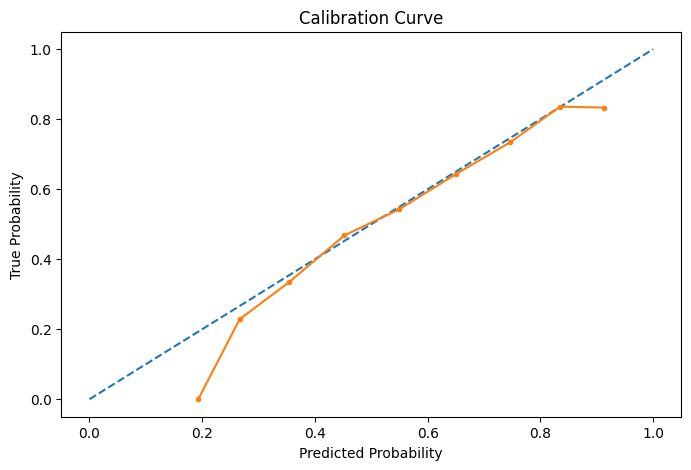

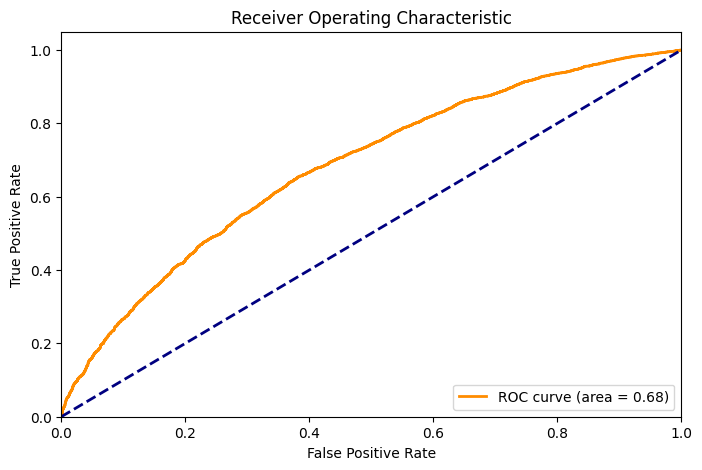

In [8]:
plot_calibration(prob_df_processed)
plot_roc_curve(prob_df_processed)

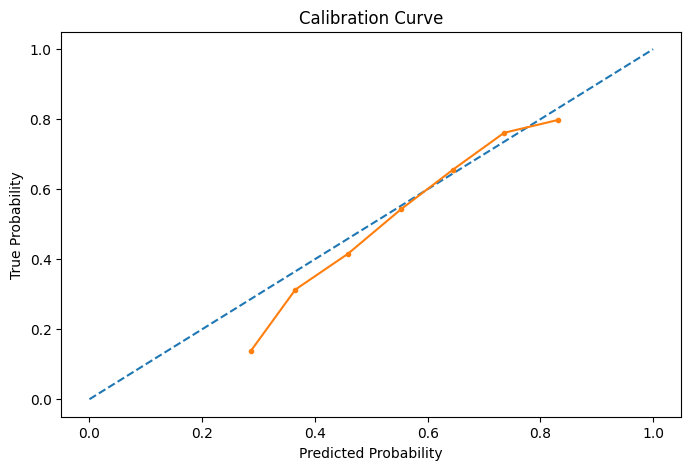

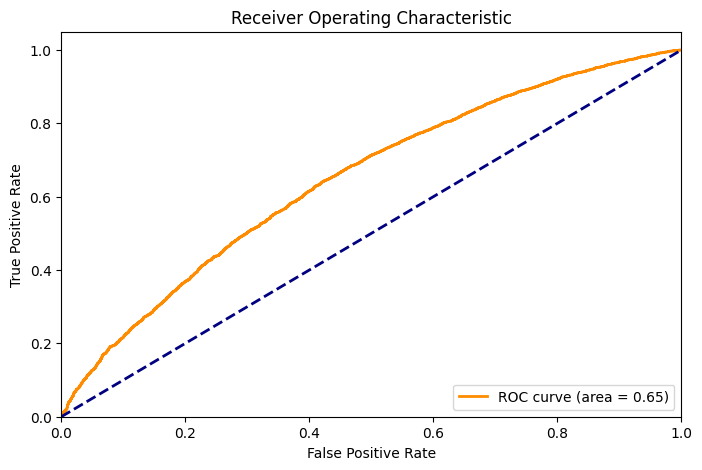

In [9]:
plot_calibration(prob_df_top_features)
plot_roc_curve(prob_df_top_features)